In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils import data
from torch import nn
from d2l import torch as d2l
%matplotlib inline

In [2]:
def load_data_mnist(batch_size):
    mnist_train = torchvision.datasets.MNIST(root="./data/mnist", 
                                                train=True, # 代表下载的是训练数据集
                                                transform=transforms.ToTensor(), # 这里将下载的数据是 tensor，而不是图片
                                                download=False) #默认从网上下载，如果事先下载好就不用设置为 T，放在指定目录即可

    mnist_test = torchvision.datasets.MNIST(root="./data/mnist", 
                                                train=False, # 代表下载的是测试数据集
                                                transform=transforms.ToTensor(), 
                                                download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True),
            data.DataLoader(mnist_test, batch_size, shuffle=True))

In [21]:
def get_net():
    max_pool = nn.MaxPool2d(2)
    conv2d_1 = nn.Conv2d(1, 6, 5, stride=1, padding=2)
    conv2d_2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
    full_con_layer_1 = nn.Linear(16 * 5 * 5, 120)
    full_con_layer_2 = nn.Linear(120, 84)
    output_layer = nn.Linear(84, 10)
    leNet = nn.Sequential(conv2d_1, nn.ReLU(),  max_pool, 
                        conv2d_2, nn.ReLU(),  max_pool,
                        nn.Flatten(start_dim=1, end_dim=-1),
                        full_con_layer_1, nn.ReLU(),
                        full_con_layer_2, nn.ReLU(),
                        output_layer, nn.Softmax()
                       ) 
    return leNet.cuda() if torch.cuda.is_available() else leNet

In [4]:
def get_loss():
    return nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [5]:
def get_updater(net, lr=1e-3):
    return torch.optim.Adam(net.parameters(), lr=lr)

In [6]:
def one_epoch_train(model: nn.Module, updater: torch.optim.Optimizer, loss, train_loss_list: list, total_train_step, train_loader):
    model.train()
    for X, y in train_loader:
        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
        l = loss(model(X), y)
        updater.zero_grad()
        l.backward()
        updater.step()
        total_train_step += 1
        train_loss_list.append(l.item())
    return total_train_step

In [7]:
def one_epoch_test(model: nn.Module, loss, test_loss_list: list, total_test_step, test_loader):
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            if torch.cuda.is_available():
                X = X.cuda()
                y = y.cuda()
            l = loss(model(X), y)
            total_test_step += 1
            test_loss_list.append(l.item())
        return total_test_step

In [8]:
def train_fn(model: nn.Module, loss, updater: torch.optim.Optimizer, num_epochs, train_loader, test_loader):
    total_train_step = 0
    total_test_step = 0
    train_loss_list = []
    test_loss_list = []
    for epoch in range(num_epochs):
        total_train_step = one_epoch_train(model, updater, loss, train_loss_list, total_train_step, train_loader)
        # if total_train_step % 10 == 0:
        print("train step: {}, train loss: {}".format(total_train_step, train_loss_list[total_train_step - 1]))
        total_test_step = one_epoch_test(model, loss, test_loss_list, total_test_step, test_loader)
        # if total_test_step % 5 == 0:
        print("test step: {}, test loss: {}".format(total_test_step, test_loss_list[total_test_step - 1]))
    return total_train_step, total_test_step, train_loss_list, test_loss_list

In [9]:
batch_size = 256
train_loader, test_loader = load_data_mnist(batch_size)

loss 1.688, train acc 0.775, test acc 0.761
38253.4 examples/sec on cuda:0


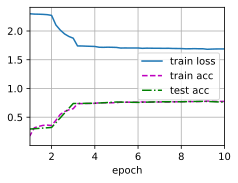

In [25]:
model = get_net()
loss = get_loss()
updater = get_updater(model, lr=0.09)
d2l.train_ch6(model, train_loader, test_loader, 10, 0.03, d2l.try_gpu())
# total_train_step, total_test_step, train_loss_list, test_loss_list = train_fn(model, loss, updater, 10, train_loader, test_loader)